In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn import linear_model, metrics, preprocessing
from math import sqrt, floor
from datetime import datetime, timedelta
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Input, LSTM,Dense,RepeatVector, TimeDistributed , LeakyReLU
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, IsolationForest
from sklearn.metrics import r2_score, make_scorer, accuracy_score, mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
import tensorflow as tf
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
import time
from sklearn.pipeline import make_pipeline, Pipeline
import math
import keras
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Input,Conv2D, Conv1D, Conv1DTranspose,MaxPooling1D

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers, Sequential
from keras.layers import Attention, GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Conv1D, BatchNormalization, RepeatVector, TimeDistributed, AveragePooling1D, UpSampling1D
import random
import pickle
import statistics
from tcn import TCN
from sklearn.metrics import f1_score

2024-01-22 22:19:34.461329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-22 22:19:34.461357: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
import ast
def temporalize(X, lookback=8):

    output_X = []
    #output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        #output_y.append(y[i + lookback + 1])
    #return np.squeeze(np.array(output_X)), np.array(output_y)
    return np.squeeze(np.array(output_X))

In [7]:
def plot_attention_weights(attention_weights, input_sequence):
    # Reshape attention weights
    attention_weights = np.squeeze(attention_weights)
    # Normalize attention weights to sum to 1
    attention_weights /= attention_weights.sum(axis=-1, keepdims=True)
    # Plot the attention weights
    plt.figure(figsize=(20, 6))
    sns.heatmap(attention_weights, cmap='Blues', annot=True, fmt=".2f", xticklabels=input_sequence, yticklabels=False)
    plt.title('Attention Weights')
    plt.xlabel('Encoded Features')
    plt.ylabel('Time Steps')
    return plt

## LSTMATTNAE

In [38]:
def LstmAttnAEModel(layer1=20, layer2=4, encoding_dim=4):
    encoder_inputs = Input(shape=(8, 8))
    
    encoder = LSTM(layer1, activation='relu', return_sequences=True)(encoder_inputs)
    encoder = LSTM(layer2, activation='relu', return_sequences=True)(encoder)
    encoder_outputs = LSTM(encoding_dim, activation='relu', return_sequences=True)(encoder)
#     encoder_outputs = RepeatVector(8)(encoder_outputs)
    attn, weights = Attention()([encoder_outputs, encoder_outputs],return_attention_scores=True )
    attn_model = Model(encoder_inputs, (attn, weights))
    attention = GlobalMaxPooling1D()(attn)
    attention = Reshape((1, encoding_dim))(attention)
    decoder = LSTM(layer2, activation='relu', return_sequences=True)(attention)
    decoder = LSTM(layer1, activation='relu', return_sequences=True)(decoder)
    decoder_outputs = TimeDistributed(Dense(8,activation='sigmoid'))(decoder)
    autoencoder = Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, attn_model
def getHyperParams(file, df_hyp):
    param_dict = ast.literal_eval(df_hyp.loc[df_hyp['file'] == file]['Hyperparameters'].values[0])
    return param_dict['model__batch_size'], param_dict['model__encoding_dim'], param_dict['model__epochs'],param_dict['model__layer1'], param_dict['model__layer2'] 

# PID Dataset

In [2]:
import sys
sys.path.pop()
sys.path.append('/mnt/work/digitwin/vpulagura_work/PID2W3Iter/')
from Models import create_autoencoder_model, ConvAEModel, ConvAttnAEModel, LstmAEModel, LstmAttnAEModel
from Models import TCNAEModel, TCNAttnAEModel, Conv_LstmAEModel, Conv_LstmAttnAEModel, ConvLstmAEModel, ConvLstmAttnAEModel
from Models import getPIDData, get_train_test_data, ae_evaluation, other_evaluation, data_unimodel, evaluation_ConvLstms

In [3]:
def LstmAttnAEModel(layer1=20, layer2=4, encoding_dim=4):
    encoder_inputs = Input(shape=(8, 137))
    
    encoder = LSTM(layer1, activation='relu', return_sequences=True)(encoder_inputs)
    encoder = LSTM(layer2, activation='relu', return_sequences=True)(encoder)
    encoder_outputs = LSTM(encoding_dim, activation='relu', return_sequences=True)(encoder)
#     encoder_outputs = RepeatVector(8)(encoder_outputs)
    attn, weights = Attention()([encoder_outputs, encoder_outputs],return_attention_scores=True )
    attn_model = Model(encoder_inputs, (attn, weights))
    attention = GlobalMaxPooling1D()(attn)
    attention = Reshape((1, encoding_dim))(attention)
    decoder = LSTM(layer2, activation='relu', return_sequences=True)(attention)
    decoder = LSTM(layer1, activation='relu', return_sequences=True)(decoder)
    decoder_outputs = TimeDistributed(Dense(137,activation='sigmoid'))(decoder)
    autoencoder = Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, attn_model

In [4]:
xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs = getPIDData()
def getHyperParams(file, df_hyp):
    param_dict = ast.literal_eval(df_hyp.loc[df_hyp['Inverter'] == file]['Feature Importance'].values[0])
    return param_dict['model__batch_size'], param_dict['model__encoding_dim'], param_dict['model__epochs'],param_dict['model__layer1'], param_dict['model__layer2'] 

(2761, 137) (11645, 137)
(2884, 137) (11231, 137)
(2884, 137) (11258, 137)
(2199, 137) (11139, 137)
(2225, 137) (10925, 137)
(2763, 137) (12281, 137)
(2655, 137) (10865, 137)
(2884, 137) (12319, 137)
(2884, 137) (8601, 137)
(2884, 137) (12146, 137)
(2884, 137) (11853, 137)
(2884, 137) (11752, 137)
(2674, 137) (12236, 137)
(2884, 137) (12122, 137)
(2884, 137) (12339, 137)
(2884, 137) (12333, 137)
(2884, 137) (12340, 137)
(2884, 137) (12339, 137)
(2884, 137) (12310, 137)


In [8]:

source_list = [12, 4, 6, 14, 10, 18, 5, 8, 3, 0, 11, 2]
total_list = [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 18]
train_merge_df = data_unimodel(source_list, xtrain_dfs)
random.shuffle(train_merge_df)
train_merge_df = temporalize(train_merge_df)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)
model, attn_model = LstmAttnAEModel(layer1=128, layer2=32, encoding_dim=32)
model.fit(train_merge_df, train_merge_df, epochs=200, batch_size=128, verbose=2,validation_split=0.1, callbacks=callback1)


2024-01-22 22:20:27.661500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-22 22:20:27.661588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-22 22:20:27.661643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-22 22:20:27.661696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-01-22 22:20:27.687703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Epoch 1/200
230/230 - 10s - loss: 0.0942 - val_loss: 0.0802 - 10s/epoch - 45ms/step
Epoch 2/200
230/230 - 6s - loss: 0.0743 - val_loss: 0.0794 - 6s/epoch - 27ms/step
Epoch 3/200
230/230 - 6s - loss: 0.0737 - val_loss: 0.0796 - 6s/epoch - 28ms/step
Epoch 4/200
230/230 - 6s - loss: 0.0734 - val_loss: 0.0786 - 6s/epoch - 27ms/step
Epoch 5/200
230/230 - 6s - loss: 0.0731 - val_loss: 0.0785 - 6s/epoch - 27ms/step
Epoch 6/200
230/230 - 6s - loss: 0.0730 - val_loss: 0.0784 - 6s/epoch - 27ms/step
Epoch 7/200
230/230 - 6s - loss: 0.0728 - val_loss: 0.0789 - 6s/epoch - 27ms/step
Epoch 8/200
230/230 - 6s - loss: 0.0728 - val_loss: 0.0782 - 6s/epoch - 27ms/step
Epoch 9/200
230/230 - 6s - loss: 0.0727 - val_loss: 0.0781 - 6s/epoch - 27ms/step
Epoch 10/200
230/230 - 6s - loss: 0.0727 - val_loss: 0.0781 - 6s/epoch - 27ms/step
Epoch 11/200
230/230 - 6s - loss: 0.0726 - val_loss: 0.0780 - 6s/epoch - 27ms/step
Epoch 12/200
230/230 - 6s - loss: 0.0726 - val_loss: 0.0780 - 6s/epoch - 27ms/step
Epoch 13/20

In [9]:
df_hyp = pd.read_csv('/mnt/work/digitwin/vpulagura_work/PID2Weeks/PID_2W_NewResults/LSTMATTNAE_HYP.csv')
inverter = 0
inv = 'inv_'+str(inverter)
xtrain, xtest, ytrain, ytest = get_train_test_data(inv, xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs)
xtrain = temporalize(xtrain)
xtest = temporalize(xtest)

In [10]:
attention_weights, attention_vector = attn_model.predict(xtrain)

with open(f'./SKAB/PIDLstmAttnWeightsMTL{inv}.pkl', 'wb') as f:
    pickle.dump(attention_weights, f)
with open(f'./SKAB/PIDLstmAttnVectortMTL{inv}.pkl', 'wb') as f:
    pickle.dump(attention_vector, f)

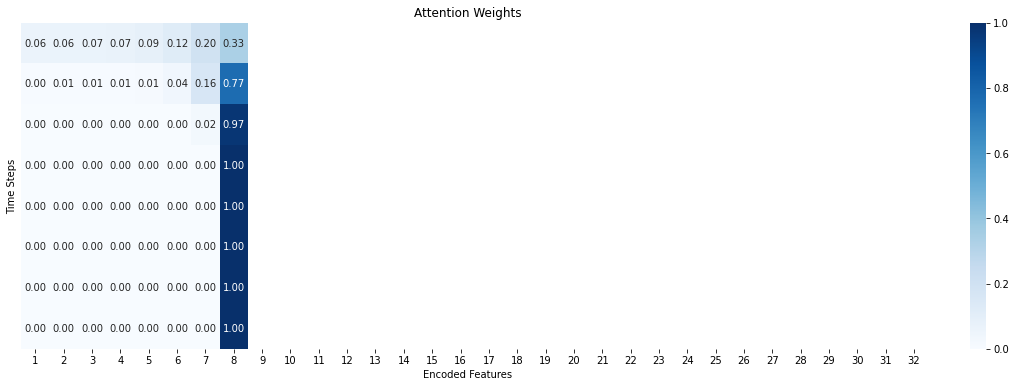

In [11]:
fig = plot_attention_weights(attention_vector[0], np.arange(1, attention_weights.shape[2]+1))
fig.savefig(f'./PIDLstmAttnWeightsMTL{inv}.png', bbox_inches='tight', dpi=300)

In [12]:
model__batch_size,model__encoding_dim, model__epochs, model__layer1, model__layer2 = getHyperParams(inverter, df_hyp)                                               
model, attn_model  = LstmAttnAEModel(layer1=model__layer1, layer2=model__layer2, encoding_dim=model__encoding_dim)
model.fit(xtrain, xtrain, epochs=model__epochs, batch_size=model__batch_size, verbose=2,validation_split=0.1, callbacks=callback1)

Epoch 1/200
20/20 - 4s - loss: 0.1825 - val_loss: 0.1949 - 4s/epoch - 214ms/step
Epoch 2/200
20/20 - 0s - loss: 0.1783 - val_loss: 0.1825 - 392ms/epoch - 20ms/step
Epoch 3/200
20/20 - 0s - loss: 0.1137 - val_loss: 0.1187 - 400ms/epoch - 20ms/step
Epoch 4/200
20/20 - 0s - loss: 0.0555 - val_loss: 0.0470 - 398ms/epoch - 20ms/step
Epoch 5/200
20/20 - 0s - loss: 0.0206 - val_loss: 0.0320 - 403ms/epoch - 20ms/step
Epoch 6/200
20/20 - 0s - loss: 0.0141 - val_loss: 0.0265 - 402ms/epoch - 20ms/step
Epoch 7/200
20/20 - 0s - loss: 0.0121 - val_loss: 0.0247 - 405ms/epoch - 20ms/step
Epoch 8/200
20/20 - 0s - loss: 0.0112 - val_loss: 0.0235 - 404ms/epoch - 20ms/step
Epoch 9/200
20/20 - 0s - loss: 0.0105 - val_loss: 0.0219 - 409ms/epoch - 20ms/step
Epoch 10/200
20/20 - 0s - loss: 0.0103 - val_loss: 0.0198 - 401ms/epoch - 20ms/step
Epoch 11/200
20/20 - 0s - loss: 0.0094 - val_loss: 0.0195 - 397ms/epoch - 20ms/step
Epoch 12/200
20/20 - 0s - loss: 0.0090 - val_loss: 0.0189 - 409ms/epoch - 20ms/step
Epo

In [16]:
attention_weights, attention_vector = attn_model.predict(xtrain)

with open(f'./SKAB/PIDLstmAttnWeightsSTL{inv}.pkl', 'wb') as f:
    pickle.dump(attention_weights, f)
with open(f'./SKAB/PIDLstmAttnVectortSTL{inv}.pkl', 'wb') as f:
    pickle.dump(attention_vector, f)

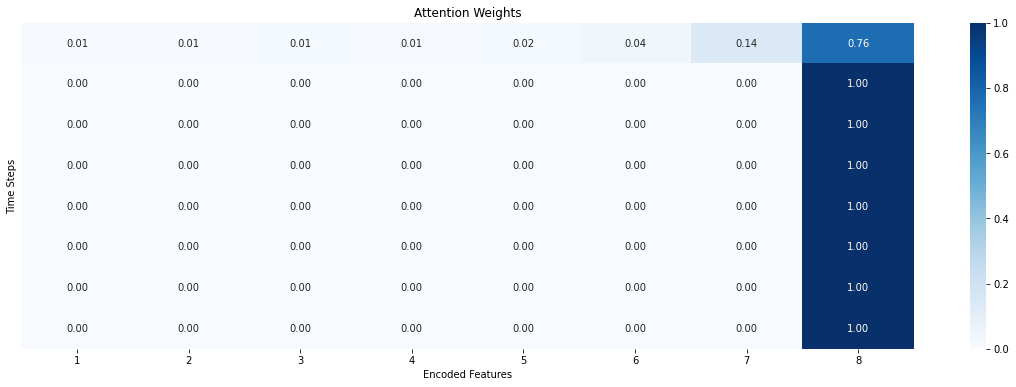

In [21]:
fig = plot_attention_weights(attention_vector[100], np.arange(1, attention_vector.shape[2]+1))
fig.savefig(f'./PIDLstmAttnWeightsSTL{inv}.png', bbox_inches='tight', dpi=300)

In [20]:
attention_vector[100]

array([[6.4302240e-03, 6.8330155e-03, 8.3199833e-03, 1.1804889e-02,
        1.8762384e-02, 4.2111605e-02, 1.4322390e-01, 7.6251394e-01],
       [4.8790529e-15, 6.7719306e-15, 2.2025543e-14, 2.1032050e-13,
        6.4720937e-12, 2.0529101e-09, 9.8147702e-06, 9.9999022e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 8.8132891e-25, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0